In [360]:
import numpy as np
from zat.log_to_dataframe import LogToDataFrame 
import zat
import pandas as pd
import matplotlib.pyplot as plt 


In [361]:
# import files etc
dataset_path = "./data/"
log_to_df = LogToDataFrame()
conn_df = log_to_df.create_dataframe(dataset_path + "conn.log")
dns_df = log_to_df.create_dataframe(dataset_path + "dns.log")
http_df = log_to_df.create_dataframe(dataset_path + "http.log")
ssl_df = log_to_df.create_dataframe(dataset_path + "ssl.log")
files_df = log_to_df.create_dataframe(dataset_path + "files.log")

# reset index for all dataframes
conn_df.reset_index(inplace=True)
dns_df.reset_index(inplace=True)
http_df.reset_index(inplace=True)
ssl_df.reset_index(inplace=True)
files_df.reset_index(inplace=True)


/Users/jakubtehlar/Documents/CTU/MGR/stratosphere/work_challenge/files/ML_ch/stratosphere_ml_challenge/.venv/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:1163: RuntimeWarning: invalid value encountered in cast
  int_data = data.astype(np.int64)


## Exploratory Data Analysis (EDA)

The goal of EDA is to find out what normal behavior in this traffic looks like. Then, pick up on these signals that suggest normal traffic and try to distinguish between benign and malicious traffic in the unknown time period. 

What I will be doing is to merge events into one minute windows. This way, I can compute the frequency of connections, number of DNS queries per minute, failed connections rate, traffic volume over time, average amount of bytes sent or received, etc.

What I do not want to do is to learn an algorithm on raw packets that happen to be in the benign time period. I intend to focus on more general patterns (features) that could back the assumption of benign behavior. This way, the model will learn from the temporal signals from the real data.

I will be focusing mostly on patterns that could indicate RAT activity, such as:
- unique DNS/hosts/IPs/domains
- traffic volume over time
- number of connections per minute
- DNS reqs per minute
- bytes sent/received 
- periodic communication

Then, after finding reliable features, I will use them for training a ML model which will be able to distinguish (or at least to indicate) benign from malicious traffic.

Before using supervised models, I will need to decide on labels in the unkown time period and then split the data set into the training and testing data. I will leave out the validation split due to the limiting amout of data available, even though the validation set could be useful for tuning the models. If I were to include the validation dataset, the three splits would be rather sparse and unfit for use. This way I will keep a reasonable amount for both training and testing.

For determining labels (0 - benign, 1 - malicious), I will use anomaly detection. 
The reason for this decision is simple - we only have the guarantee of benign data up to 4 minutes of the dataset. 
This is exactly on what anomaly detection algorithms work - they are given a set of samples belonging to one class and their task is to decide whether an unseen data belong to the same class the model was exposed to during training.

I am, however, very well aware of the size of the dataset. This is why I will use a bit more robust approach - I will employ two detection methods (due to time reasons only 2), each method will provide a label for the data and only those data points flagged as anomalies by both methods will be eventually treated as anomalies. 
I am not sure whether this is the ideal course of action, but due to the small size of the dataset, I think this ansamble detection approach is valid.

In [362]:
# explore the conn_df
conn_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,dns,0 days 00:00:00.010542,31,...,SF,NaN,NaN,0,Dd,1,59,1,108,NaN
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,dns,0 days 00:00:00.010908,33,...,SF,NaN,NaN,0,Dd,1,61,1,115,NaN
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,dns,0 days 00:00:00.010734,50,...,SF,NaN,NaN,0,Dd,1,78,1,94,NaN
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,dns,0 days 00:00:00.010405,37,...,SF,NaN,NaN,0,Dd,1,65,1,119,NaN
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,dns,0 days 00:00:00.009332,40,...,SF,NaN,NaN,0,Dd,1,68,1,108,NaN


In [363]:
conn_df.describe()

,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,223,223.0,223.0,190,190.0,190.0,223.0,223.0,223.0,223.0,223.0
mean,2020-09-02 14:48:23.848390656,42422.663677,3103.076233,0 days 00:01:06.408112805,6458.863158,186627.715789,0.0,74.789238,9729.116592,132.03139,168489.753363
min,2020-09-02 14:33:23.796334982,3.0,4.0,0 days 00:00:00.000043,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2020-09-02 14:35:18.751427584,38248.0,53.0,0 days 00:00:00.010982,37.0,64.0,0.0,1.0,65.0,1.0,81.0
50%,2020-09-02 14:38:52.271037184,47812.0,443.0,0 days 00:00:03.003519500,482.0,293.5,0.0,3.0,180.0,1.0,148.0
75%,2020-09-02 15:04:43.380082432,52304.0,5228.0,0 days 00:00:39.887839500,1749.75,3727.0,0.0,15.0,2201.0,13.0,3368.5
max,2020-09-02 15:36:57.062417030,65449.0,57736.0,0 days 00:30:08.665546,692835.0,18081893.0,0.0,6927.0,731444.0,13717.0,18795185.0
std,NaN,16515.438133,8078.990258,0 days 00:02:52.760371969,51082.396905,1401233.614579,0.0,503.116911,56719.860387,986.536878,1352416.032459


In [364]:
conn_df.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents'],
      dtype='str')

In [365]:
all_dfs = [conn_df, dns_df, http_df, ssl_df, files_df]

for df in all_dfs:
    print(f"Rows: {len(df)}, Columns: {len(df.columns)}, Time range from {df['ts'].min()} to {df['ts'].max()}")

Rows: 223, Columns: 21, Time range from 2020-09-02 14:33:23.796334982 to 2020-09-02 15:36:57.062417030
Rows: 64, Columns: 24, Time range from 2020-09-02 14:33:23.796334982 to 2020-09-02 15:27:20.297641993
Rows: 25, Columns: 30, Time range from 2020-09-02 14:33:23.810384989 to 2020-09-02 15:05:59.264569043
Rows: 78, Columns: 21, Time range from 2020-09-02 14:33:48.338402033 to 2020-09-02 15:27:20.309696913
Rows: 70, Columns: 25, Time range from 2020-09-02 14:33:51.558053017 to 2020-09-02 15:05:59.382664919


In [366]:
# timestamps
start_time = conn_df["ts"].min() 
end_time = conn_df["ts"].max()
print(f"Start time: {start_time}, End time: {end_time}")

Start time: 2020-09-02 14:33:23.796334982, End time: 2020-09-02 15:36:57.062417030


In [367]:
# Unique DNS
dns_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,15630,0 days 00:00:00.010542,portal.fb.com,...,0,NOERROR,F,F,T,T,0,"star.c10r.facebook.com,157.240.30.18","174.000000,59.000000",F
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,35052,0 days 00:00:00.010908,i.instagram.com,...,0,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,2.000000",F
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,55600,0 days 00:00:00.010734,scontent-prg1-1.cdninstagram.com,...,0,NOERROR,F,F,T,T,0,157.240.30.63,59.000000,F
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,39507,0 days 00:00:00.010405,graph.instagram.com,...,0,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,30.000000",F
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,41491,0 days 00:00:00.009332,edge-mqtt.facebook.com,...,0,NOERROR,F,F,T,T,0,"mqtt.c10r.facebook.com,157.240.30.11","1236.000000,37.000000",F


In [368]:
# queries
dns_df["query"].unique()

['portal.fb.com', 'i.instagram.com', 'scontent-prg1-1.cdninstagram.com', 'graph.instagram.com', 'edge-mqtt.facebook.com', ..., 'android.clients.google.com', 'mtalk.google.com', 'play.googleapis.com', 'app-measurement.com', 'people-pa.googleapis.com']
Length: 46
Categories (46, str): ['android-safebrowsing.google.com', 'android.clients.google.com', 'android.googleapis.com', 'api-24-0-0.twitter.com', ..., 'video.twimg.com', 'www.facebook.com', 'www.googleapis.com', 'www.msftconnecttest.com']

In [369]:
# DNS servers
dns_df["id.resp_h"].unique()

['8.8.8.8']
Categories (1, str): ['8.8.8.8']

In [370]:
# Client IPs
dns_df["id.orig_h"].unique()

['10.8.0.117']
Categories (1, str): ['10.8.0.117']

Text(0.5, 1.0, 'Number of connections per domain query')

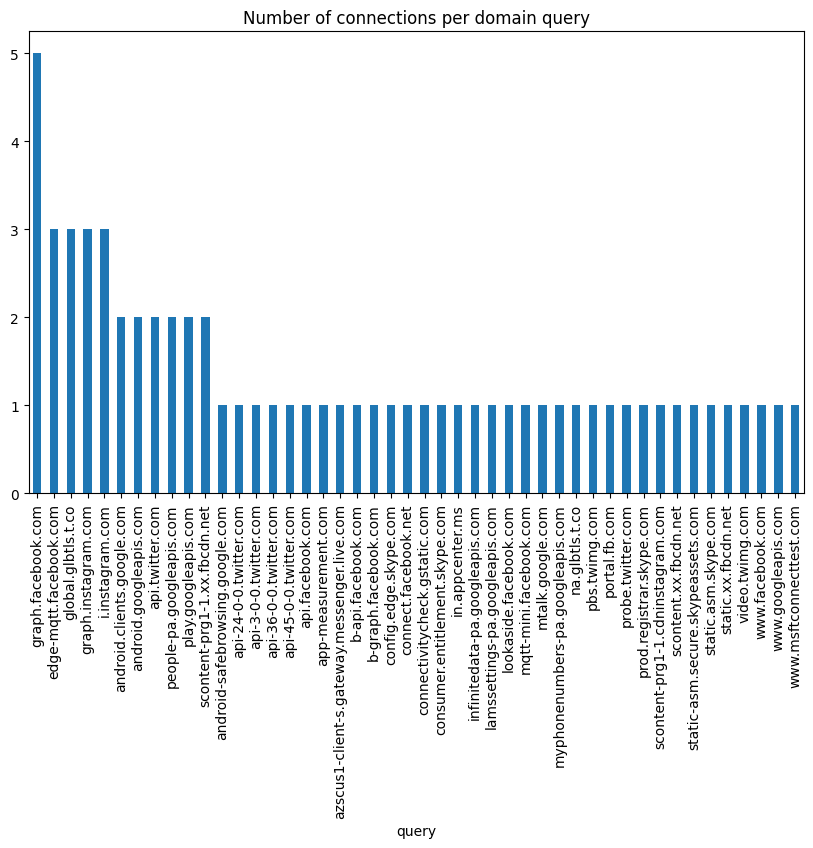

In [371]:
# Plot of connections for each domain query
counts = dns_df["query"].value_counts()

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
plt.title("Number of connections per domain query")


Text(0.5, 1.0, 'Number of connections per domain')

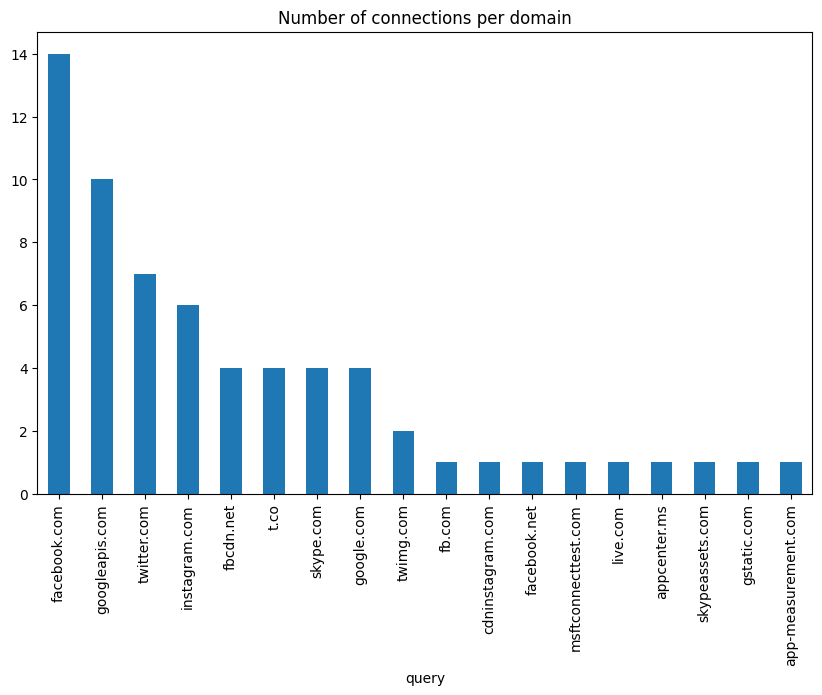

In [372]:
# As showed above, there are only few unique domain queries, I will merge all queries of the same domain together
# to have a better understanding of the number of connections per domain 

queries = dns_df["query"]
# x.split(".") - split the query, e.g. -> [www, google, com]
# x.split(".")[-2:] - take the domain name and TLD
# ".".join(...) - join the domain name and TLD back together
domains = queries.apply(lambda x: ".".join((x.split("."))[-2:]))
domains_unique = domains.unique()
counts_ = domains.value_counts()
plt.figure(figsize=(10, 6))
counts_.plot(kind="bar")
plt.title("Number of connections per domain")

In [373]:
# Connections & DNS queries per minute
conns_per_min = conn_df.set_index("ts").resample("1min").size()
conns_per_min


ts
2020-09-02 14:33:00    20
2020-09-02 14:34:00    26
2020-09-02 14:35:00    18
2020-09-02 14:36:00    34
2020-09-02 14:37:00     7
                       ..
2020-09-02 15:32:00     0
2020-09-02 15:33:00     0
2020-09-02 15:34:00     0
2020-09-02 15:35:00     0
2020-09-02 15:36:00     1
Freq: min, Length: 64, dtype: int64

In [374]:
# Connections per minute in the first 4 minutes
conns_per_min[:4]
num_conns_benign = conns_per_min[:4].sum()
print(f"Number of connections in the first 4 minutes: {num_conns_benign}")

# Connections per minute for the rest
num_conns_unknown = conns_per_min[4:].sum()
print(f"Number of connections in the rest: {num_conns_unknown}")


Number of connections in the first 4 minutes: 98
Number of connections in the rest: 125


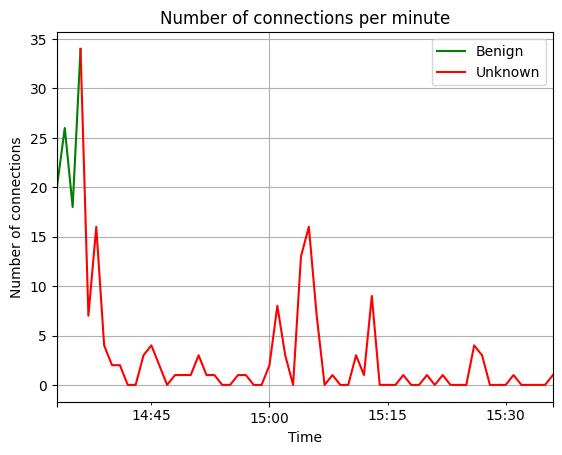

In [375]:
# Plotting connections per minute
conns_per_min[:4].plot(label="Benign", color="green")
conns_per_min[3:].plot(label="Unknown", color="red")
plt.title("Number of connections per minute")
plt.xlabel("Time")
plt.ylabel("Number of connections")
plt.legend()
plt.grid()
plt.show()


In [376]:
# DNS queries per minute
dns_per_min = dns_df.set_index("ts").resample("1min").size()

# DNS queries per minute in the first 4 minutes
num_dns_benign = dns_per_min[:4].sum()
print(f"Number of DNS queries in the first 4 minutes: {num_dns_benign}")

# DNS queries per minute for the rest
num_dns_unknown = dns_per_min[4:].sum()
print(f"Number of DNS queries in the rest: {num_dns_unknown}")

Number of DNS queries in the first 4 minutes: 41
Number of DNS queries in the rest: 23


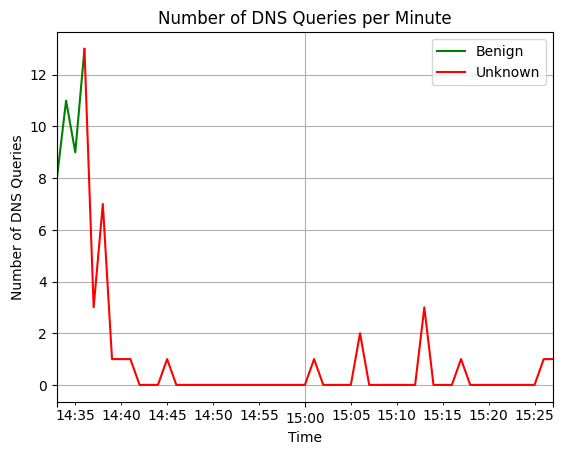

In [377]:
# Plotting DNS queries per minute
dns_per_min[:4].plot(label="Benign", color="green")
dns_per_min[3:].plot(label="Unknown", color="red")
plt.title("Number of DNS Queries per Minute")
plt.xlabel("Time")
plt.ylabel("Number of DNS Queries")
plt.legend()
plt.grid()
plt.show()

This plot shows signs of periodic beaconing. ~15:00; ~15:05; ~15:12; ~15:17

In [378]:
conns_per_min.head(10)


ts
2020-09-02 14:33:00    20
2020-09-02 14:34:00    26
2020-09-02 14:35:00    18
2020-09-02 14:36:00    34
2020-09-02 14:37:00     7
2020-09-02 14:38:00    16
2020-09-02 14:39:00     4
2020-09-02 14:40:00     2
2020-09-02 14:41:00     2
2020-09-02 14:42:00     0
Freq: min, dtype: int64

In [379]:
conns_per_min.describe()

count    64.000000
mean      3.484375
std       6.697529
min       0.000000
25%       0.000000
50%       1.000000
75%       3.000000
max      34.000000
dtype: float64

In [380]:
dns_per_min.head(10)

ts
2020-09-02 14:33:00     8
2020-09-02 14:34:00    11
2020-09-02 14:35:00     9
2020-09-02 14:36:00    13
2020-09-02 14:37:00     3
2020-09-02 14:38:00     7
2020-09-02 14:39:00     1
2020-09-02 14:40:00     1
2020-09-02 14:41:00     1
2020-09-02 14:42:00     0
Freq: min, dtype: int64

In [381]:
dns_per_min.describe()

count    55.000000
mean      1.163636
std       2.852962
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      13.000000
dtype: float64

The blocks above show that the traffic volume in the benign period is rather heavier than in the unknown period. 
This could be an indication of RAT, where the malware could be periodically quering the same domains rather than trying to connect to a pool of random websites to be more off radar.

In [382]:
# Analysis of traffic after the first 4 minutes - the unknown data
start_time_unknown = start_time + pd.Timedelta(minutes=4)

# Drop the index 
# conn_df.reset_index(inplace=True)

# # Filter the dataframes to only include data after the first 4 minutes
# conn_df_unknown = conn_df[conn_df["ts"] >= start_time_unknown]
# dns_df_unknown = dns_df[dns_df["ts"] >= start_time_unknown]
# http_df_unknown = http_df[http_df["ts"] >= start_time_unknown]
# ssl_df_unknown = ssl_df[ssl_df["ts"] >= start_time_unknown]
# files_df_unknown = files_df[files_df["ts"] >= start_time_unknown]

In [383]:
# Label the dataframes with "benign" for the first 4 minutes and "unknown" for the remaining data
conn_df["label"] = np.where(conn_df["ts"] < start_time_unknown, "benign", "unknown")
dns_df["label"] = np.where(dns_df["ts"] < start_time_unknown, "benign", "unknown")

In [384]:
conn_df.head(100)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,dns,0 days 00:00:00.010542,31,...,NaN,NaN,0,Dd,1,59,1,108,NaN,benign
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,dns,0 days 00:00:00.010908,33,...,NaN,NaN,0,Dd,1,61,1,115,NaN,benign
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,dns,0 days 00:00:00.010734,50,...,NaN,NaN,0,Dd,1,78,1,94,NaN,benign
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,dns,0 days 00:00:00.010405,37,...,NaN,NaN,0,Dd,1,65,1,119,NaN,benign
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,dns,0 days 00:00:00.009332,40,...,NaN,NaN,0,Dd,1,68,1,108,NaN,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-09-02 14:38:48.422017097,CWApfN3UTvjGLZyJKl,10.8.0.117,19962,8.8.8.8,53,udp,dns,0 days 00:00:00.011190,36,...,NaN,NaN,0,Dd,1,64,1,122,NaN,unknown
96,2020-09-02 14:38:50.206635952,CGolb645kmwKxfZxt7,10.8.0.117,13900,8.8.8.8,53,udp,dns,0 days 00:00:00.011724,33,...,NaN,NaN,0,Dd,1,61,1,115,NaN,unknown
97,2020-09-02 14:38:50.940470934,CXDHlA1iGWzdQS7LIc,10.8.0.117,27862,8.8.8.8,53,udp,dns,0 days 00:00:00.010512,37,...,NaN,NaN,0,Dd,1,65,1,119,NaN,unknown
98,2020-09-02 14:38:52.271037102,CmwWGt1PO1uaGODfjd,10.8.0.117,14443,8.8.8.8,53,udp,dns,0 days 00:00:00.016970,49,...,NaN,NaN,0,Dd,1,77,1,112,NaN,unknown


In [385]:
dns_df.head(100)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected,label
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,15630,0 days 00:00:00.010542,portal.fb.com,...,NOERROR,F,F,T,T,0,"star.c10r.facebook.com,157.240.30.18","174.000000,59.000000",F,benign
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,35052,0 days 00:00:00.010908,i.instagram.com,...,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,2.000000",F,benign
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,55600,0 days 00:00:00.010734,scontent-prg1-1.cdninstagram.com,...,NOERROR,F,F,T,T,0,157.240.30.63,59.000000,F,benign
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,39507,0 days 00:00:00.010405,graph.instagram.com,...,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,30.000000",F,benign
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,41491,0 days 00:00:00.009332,edge-mqtt.facebook.com,...,NOERROR,F,F,T,T,0,"mqtt.c10r.facebook.com,157.240.30.11","1236.000000,37.000000",F,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2020-09-02 15:13:09.453067064,Cyw1E94W8FfeSPczJk,10.8.0.117,60718,8.8.8.8,53,udp,64687,0 days 00:00:00.018982,android.googleapis.com,...,NOERROR,F,F,T,T,0,216.58.201.74,299.000000,F,unknown
60,2020-09-02 15:13:39.478319883,C0jMGu1frh9ei1Wmqc,10.8.0.117,60710,8.8.8.8,53,udp,48649,0 days 00:00:00.009136,people-pa.googleapis.com,...,NOERROR,F,F,T,T,0,216.58.201.106,247.000000,F,unknown
61,2020-09-02 15:17:56.417140961,COs0MF2BvtxqwwWZBl,10.8.0.117,16281,8.8.8.8,53,udp,23329,0 days 00:00:00.009862,people-pa.googleapis.com,...,NOERROR,F,F,T,T,0,216.58.201.106,248.000000,F,unknown
62,2020-09-02 15:26:19.691025019,CovR8F24TUZtn0RYGj,10.8.0.117,1075,8.8.8.8,53,udp,36482,0 days 00:00:00.009263,global.glbtls.t.co,...,NOERROR,F,F,T,T,0,34.102.215.127,576.000000,F,unknown


In [386]:
conn_df.groupby("label")["id.resp_h"].nunique()

label
benign     30
unknown    20
Name: id.resp_h, dtype: int64

This raises suspicionn as the number of unique destinations in the unknown time period has decreased by a 1/3. 
If the communication is taking place with the same host, this could reveal the malicious actor.

In [387]:
dns_df.groupby("label")["query"].nunique()

label
benign     37
unknown    16
Name: query, dtype: int64

There is a significant decrease in DNS queries in the unknown time period as well. 

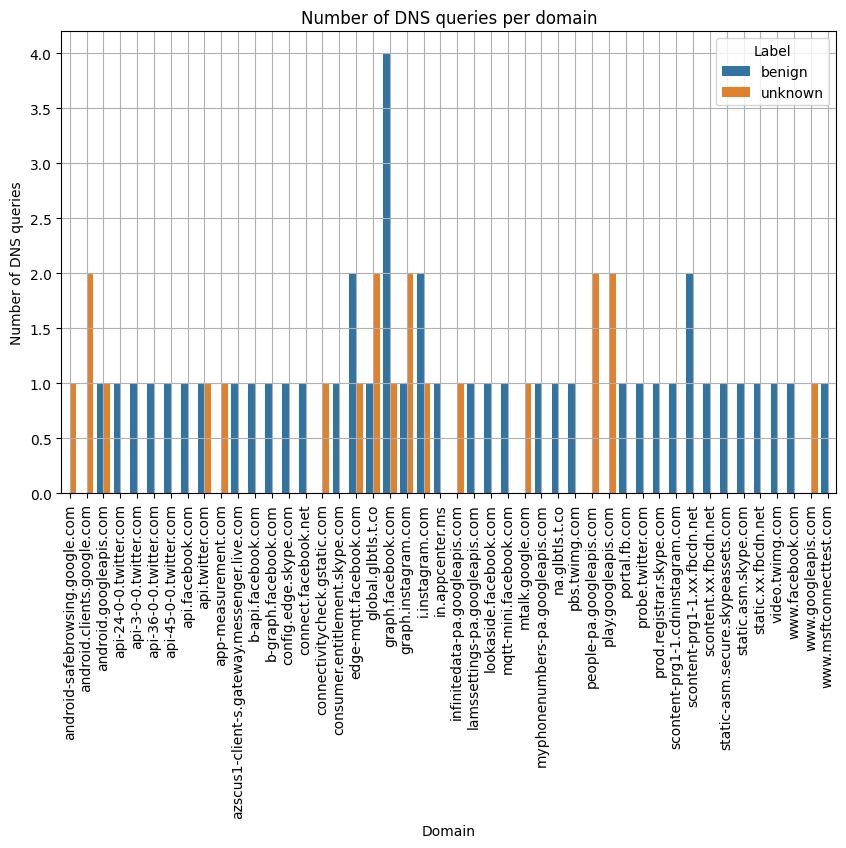

In [388]:
# Plot a histogram of DNS queries for each domain in the benign and unkown time period
import seaborn as sns   
dns_df["domain"] = dns_df["query"]
plt.figure(figsize=(10, 6))
sns.countplot(data=dns_df, x="domain", hue="label")
plt.title("Number of DNS queries per domain")
plt.xlabel("Domain")
plt.ylabel("Number of DNS queries")
plt.xticks(rotation=90)
plt.legend(title="Label")
plt.grid()
plt.show()

In [389]:
# Top domains searched in the unknown period
dns_df[dns_df["label"] == "unknown"]["domain"].value_counts().head(10)

domain
android.clients.google.com         2
global.glbtls.t.co                 2
graph.instagram.com                2
people-pa.googleapis.com           2
play.googleapis.com                2
android-safebrowsing.google.com    1
android.googleapis.com             1
api.twitter.com                    1
app-measurement.com                1
connectivitycheck.gstatic.com      1
Name: count, dtype: int64

From the first look, there are occurences of domains like facebook, twitter, instagram or google APIs (used by android apps for example), which are clean.

It is possible to go further in this analysis and lookup individual websites in a sandbox or verify them using online tools like VirusTotal or Scam Adviser. If some websites happened to have low trust scores or proved to be indeed malicious, this could narrow down the window for malware presence.

In [390]:

# Top domains searched in the benign period
dns_df[dns_df["label"] == "benign"]["domain"].value_counts().head(10)

domain
graph.facebook.com              4
edge-mqtt.facebook.com          2
i.instagram.com                 2
scontent-prg1-1.xx.fbcdn.net    2
android.googleapis.com          1
api-24-0-0.twitter.com          1
api-3-0-0.twitter.com           1
api-36-0-0.twitter.com          1
api-45-0-0.twitter.com          1
api.facebook.com                1
Name: count, dtype: int64

In [391]:
# Repeated communication
top_ips = conn_df[conn_df['label']=='unknown']['id.resp_h'].value_counts().head(10)
top_ips


id.resp_h
147.32.83.230     50
8.8.8.8           21
10.8.0.117        11
69.171.250.20      6
34.102.215.127     5
157.240.30.34      4
157.240.30.63      3
172.217.23.234     3
216.58.201.106     3
74.125.71.188      3
Name: count, dtype: int64

Based on the DNS lookup (using dnschecker.org), I found out the following:
- the most repeated host (147.32.83.230) belongs to dhcp-83-230.felk.cvut.cz
- 8.8.8.8 belongs to google

<Axes: title={'center': 'Communication frequency with 147.32.83.230'}, xlabel='ts'>

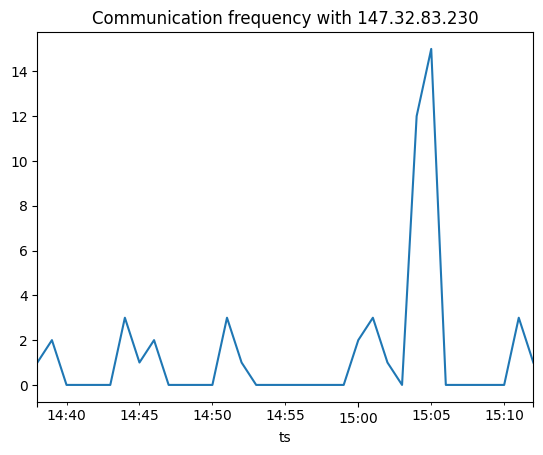

In [392]:
ip = top_ips.index[0]
conn_df[conn_df["id.resp_h"] == ip].set_index('ts').resample('1min').size().plot(
    title=f"Communication frequency with {ip}"
)


In [393]:
# bytes comparison
conn_df.groupby('label')[['orig_bytes','resp_bytes']].mean()


,orig_bytes,resp_bytes
label,,
benign,2617.049505,350174.326733
unknown,10818.674157,1029.876404


Another idea I have in mind is to check those domains that appeared only in the unknown time period (and not in the benign). By doing this, it might reveal what the RAT running on the device could be doing. However, as shown in the block below, the only new domains were related to google APIs or google in general, which are heavily used by android apps. I cannot derive anyting suspicious.

In [394]:
# Lets determine new domains in the unkown period
domains_benign = dns_df[dns_df["label"] == "benign"]["query"].unique()
domains_unknown = dns_df[dns_df["label"] == "unknown"]["query"].unique()
# the domains that are in the unknown period but not in the benign period
new_domains = set(domains_unknown) - set(domains_benign)
new_domains 

{'android-safebrowsing.google.com',
 'android.clients.google.com',
 'app-measurement.com',
 'connectivitycheck.gstatic.com',
 'infinitedata-pa.googleapis.com',
 'mtalk.google.com',
 'people-pa.googleapis.com',
 'play.googleapis.com',
 'www.googleapis.com'}

Another thing worth checking are the used ports used in the communication (in both time periods). If there are any unusual ports, this could reveal what services could be running there and help figure out what the RAT is doing.

In [395]:
conn_df[conn_df["label"] == "benign"]["id.resp_p"].value_counts()

id.resp_p
443     54
53      43
4        2
80       2
1900     1
Name: count, dtype: Int64

- Port 443 - TCP, used for HTTPS
- Port 53 - standard port for DNS
- Port 4 - not standard, historically associated with legacy systems like SFS
- Port 80 - HTTP
- Port 1900 - default port used for the SSDP (detecting network devices like printers etc)

In [396]:
conn_df[conn_df["label"] == "unknown"]["id.resp_p"].value_counts()

id.resp_p
8000     50
443      36
53       21
4         7
57736     4
5228      3
Name: count, dtype: Int64

- Port 8000 - TCP, used for web development and similar services
- Port 57736 - commonly used by client applications for temporary connections
- Port 5228 - UDP/TCP port used by Google services


In [397]:
# Lets see the communication taking place at rarely used ports in the unknown period - ports 5228, 57736, and 4 
rare_ports = [5228, 57736, 4]
conn_df_unknown_rare = conn_df[(conn_df["label"] == "unknown") & (conn_df["id.resp_p"].isin(rare_ports))]
conn_df_unknown_rare

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label
108,2020-09-02 14:38:52.319050074,CHTNtx4Fle9gvLfoDe,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:30.622713,3836,...,NaN,NaN,0,NaN,7,4032,0,0,NaN,unknown
131,2020-09-02 14:45:01.674946070,CLfWhl4LNwbNxuP75c,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:07.854616,1644,...,NaN,NaN,0,NaN,3,1728,0,0,NaN,unknown
133,2020-09-02 14:41:18.395142078,CE4MFJ1RAv9jD7j8f4,10.8.0.117,57736,74.125.71.188,5228,tcp,ssl,0 days 00:00:00.123012,1025,...,NaN,NaN,0,ShADad,8,1449,8,1274,NaN,unknown
141,2020-09-02 14:48:38.847400904,CLcQhW1SxpdlwFMcna,74.125.71.188,5228,10.8.0.117,57736,tcp,NaN,0 days 00:00:00.021791,24,...,NaN,NaN,0,DadA,2,128,2,132,NaN,unknown
144,2020-09-02 14:56:41.531064034,ClWzPf3oMl4uVjOMT3,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:00.000043,1096,...,NaN,NaN,0,NaN,2,1152,0,0,NaN,unknown
150,2020-09-02 14:57:28.858843088,Czch711A3bfMwIhkpd,10.8.0.117,57736,74.125.71.188,5228,tcp,NaN,0 days 00:00:00.063941,28,...,NaN,NaN,0,DadA,2,132,2,130,NaN,unknown
152,2020-09-02 15:02:29.594460964,CB5LlJ8vbIPKf578d,10.8.0.1,3,10.8.0.117,4,icmp,NaN,NaT,<NA>,...,NaN,NaN,0,NaN,1,576,0,0,NaN,unknown
186,2020-09-02 15:06:50.240808964,CKbPzpWdWOGdrwMaj,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:00.001371,3288,...,NaN,NaN,0,NaN,6,3456,0,0,NaN,unknown
195,2020-09-02 15:06:49.350353956,CDJdZD4p2nNj5M9357,74.125.71.188,5228,10.8.0.117,57736,tcp,NaN,0 days 00:00:00.022804,24,...,NaN,NaN,0,DadA,2,128,2,136,NaN,unknown
204,2020-09-02 15:13:09.500013112,CTR20RJdctfs2S6Vd,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:30.022600,3288,...,NaN,NaN,0,NaN,6,3456,0,0,NaN,unknown


Failed connections/short sessions could also reveal malicious activity. Let's check.

In [398]:
# Lets see failed connections in the unknown period
failed_conns = conn_df[(conn_df["label"] == "unknown") & (conn_df["conn_state"] == "REJ")]
failed_conns

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label


In [399]:
# Lets see short sessions in the unknown period
short_sessions = conn_df[(conn_df["label"] == "unknown") & (conn_df["duration"] < pd.Timedelta(seconds=1))] 
short_sessions

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label
88,2020-09-02 14:37:34.019953012,CF9VVu1vAvWE78HkF1,10.8.0.117,60754,69.171.250.20,443,tcp,ssl,0 days 00:00:00.195208,2092,...,NaN,NaN,0,ShADadR,20,3140,16,1805,NaN,unknown
92,2020-09-02 14:37:34.022548914,CIus7m9I8DcRDgV03,10.8.0.117,27542,8.8.8.8,53,udp,dns,0 days 00:00:00.000852,40,...,NaN,NaN,0,Dd,1,68,1,108,NaN,unknown
93,2020-09-02 14:38:52.290865898,CizSET1Lj8XzlMpzD5,10.8.0.117,52488,216.58.201.110,443,tcp,ssl,0 days 00:00:00.274887,2893,...,NaN,NaN,0,ShADadTfF,13,4926,12,5848,NaN,unknown
95,2020-09-02 14:38:48.422017097,CWApfN3UTvjGLZyJKl,10.8.0.117,19962,8.8.8.8,53,udp,dns,0 days 00:00:00.011190,36,...,NaN,NaN,0,Dd,1,64,1,122,NaN,unknown
96,2020-09-02 14:38:50.206635952,CGolb645kmwKxfZxt7,10.8.0.117,13900,8.8.8.8,53,udp,dns,0 days 00:00:00.011724,33,...,NaN,NaN,0,Dd,1,61,1,115,NaN,unknown
97,2020-09-02 14:38:50.940470934,CXDHlA1iGWzdQS7LIc,10.8.0.117,27862,8.8.8.8,53,udp,dns,0 days 00:00:00.010512,37,...,NaN,NaN,0,Dd,1,65,1,119,NaN,unknown
98,2020-09-02 14:38:52.271037102,CmwWGt1PO1uaGODfjd,10.8.0.117,14443,8.8.8.8,53,udp,dns,0 days 00:00:00.016970,49,...,NaN,NaN,0,Dd,1,77,1,112,NaN,unknown
99,2020-09-02 14:38:52.865408897,CYEFZr4yOdql0M1oO6,10.8.0.117,25502,8.8.8.8,53,udp,dns,0 days 00:00:00.009222,47,...,NaN,NaN,0,Dd,1,75,1,91,NaN,unknown
100,2020-09-02 14:38:52.913239956,C9vurc2Yk07T7yT3G8,10.8.0.117,15204,8.8.8.8,53,udp,dns,0 days 00:00:00.028430,48,...,NaN,NaN,0,Dd,1,76,1,92,NaN,unknown
101,2020-09-02 14:38:53.745862007,CgEcRA4GoAPDj01OAf,10.8.0.117,15257,8.8.8.8,53,udp,dns,0 days 00:00:00.009246,36,...,NaN,NaN,0,Dd,1,64,1,128,NaN,unknown


By conducting EDA, I was able to find out the following:
- number of connections and DNS queries decrease in the unknown period by a third - possible indication of RAT
- most queried domains belong to google or use google API services which could, but do not necessarily imply any malicious activity
- the client the device most communicated with in the unknown period belongs to felk.cvut.cz
- the mean of incoming/outgoing bytes decreased by approximately a half in the unknown time period
- the communication in the unknown period uses mostly standard and well-known ports (except for port 4)
- no failed connections in the unknown time period

## Anomaly detection + ML models

Below I apply unsupervised and supervised ML methods described in the introductory section. 
The approach consists of
- anomaly detection with Isolation Forest and One-Class SVM
- feature selection
- model training and evaluation

The logic behind the selected anomaly detection algorithms:
- Isolation Forest - low complexity (~O(n)) and is more robust to noise but will probably overfit as the dataset is quite small and imbalanced
- One-Class SVM - usually high accuracy and if necessary could be used with a kernel to better fit the data

Other possibilities for anomaly detection in this task could be distance based methods like K-NN or similar Local Outlier Factor 

### Features 
- connections per minute
- dns queries per minute
- bytes in/out
- unique destination IPs
- unique destination ports
- unique domains
- top IP destination frequency
- top destination port frequency
- new domains per minute
- new IPs per minute
- failed connections rate
- Isolation Forest anomaly scores
- One-class SVM anomaly scores

Although this is a rich set of features, I am not sure if the model will not overfit on such a small data set.

The procedure goes as follows:
- Fit IF & O-C SVM on benign traffic features
- generate anomaly scores for unknown period, classify samples based on adjusted anomaly scores (shown in the analysis below)
- data points labeled by both detection methods are treated as anomalies
- split the data - the training and testing set
- use scaler and train and evaluate several classifiers - Random Forest, SVM, Logistic Regression (where Random Forest could be useful in particular for capturing non-linear relationships where will linear classifiers likely fail)

In [400]:
# connection features
conn_window = conn_df.set_index("ts").resample("1min").agg({
    "id.resp_h": pd.Series.nunique,  # number of unique destination IPs
    "id.resp_p": pd.Series.nunique,  # number of unique destination ports 
    "orig_bytes": "sum",  # total bytes sent by the source
    "resp_bytes": "sum",  # total bytes sent by the destination
    # "duration": "mean",  # average duration of connections
    "conn_state": pd.Series.nunique  # number of unique connection states
})

conn_window.columns = [
    "unique_dest_ips",
    "unique_dest_ports",
    "total_orig_bytes",
    "total_resp_bytes",
    # "duration_mean",
    "conn_state_diversity",
]


In [401]:
# dns features
dns_df["is_new_domain"] = dns_df["query"].apply(lambda x: 1 if x in new_domains else 0)

dns_window = dns_df.set_index("ts").resample("1min").agg({
    "query": ["count", pd.Series.nunique],  # number of unique queries
    "is_new_domain": "sum"  # number of new domains
})

dns_window.columns = [
    "count_queries",
    "unique_queries",
    "new_domains_count",
]


In [402]:
# frequency features
freq_window = conn_df.set_index("ts").resample("1min").agg({
    "id.resp_h": pd.Series.nunique,  # number of unique destination IPs
    "id.resp_p": pd.Series.nunique,  # number of unique destination ports 
})

In [403]:
bytes_window = conn_df.set_index("ts").resample("1min").agg({
    "orig_bytes": "sum",  # total bytes sent by the source
    "resp_bytes": "sum",  # total bytes sent by the destination
})

In [404]:
# Merging all features into a single dataframe
features_df = pd.concat([
    conn_window,
    dns_window,
    freq_window,
    bytes_window,
], axis=1)

features_df = features_df.fillna(0)

In [405]:
benign_features = features_df[features_df.index < start_time_unknown]
unknown_features = features_df[features_df.index >= start_time_unknown]


In [406]:
# contamination rate based on the number of connections in the unknown period
contamination_rate = num_conns_unknown / (num_conns_benign + num_conns_unknown)
print(f"Contamination rate: {contamination_rate:.2f}")

Contamination rate: 0.56


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# use the estimate of the contamination rate to set the threshold for anomaly detectio
# for better fit, crossvalidation of parameters could be applied
iso = IsolationForest(n_estimators=100, contamination=0.5, random_state=42)
iso.fit(benign_features)
anomaly_scores = iso.decision_function(unknown_features)
anomalies = iso.predict(unknown_features)
print("Anomalies in the unknown period:")
unknown_features[anomalies == -1]

Anomalies in the unknown period:


,unique_dest_ips,unique_dest_ports,total_orig_bytes,total_resp_bytes,conn_state_diversity,count_queries,unique_queries,new_domains_count,id.resp_h,id.resp_p,orig_bytes,resp_bytes
ts,,,,,,,,,,,,
2020-09-02 14:39:00,3,3,5615,2621,2,1.0,1.0,1.0,3,3,5615,2621
2020-09-02 14:40:00,2,2,33534,1408,1,1.0,1.0,0.0,2,2,33534,1408
2020-09-02 14:41:00,2,2,1059,929,2,1.0,1.0,1.0,2,2,1059,929
2020-09-02 14:42:00,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0
2020-09-02 14:43:00,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0
2020-09-02 14:44:00,1,1,0,0,1,0.0,0.0,0.0,1,1,0,0
2020-09-02 14:45:00,4,4,4551,4146,4,1.0,1.0,1.0,4,4,4551,4146
2020-09-02 14:46:00,1,1,693689,1546,2,0.0,0.0,0.0,1,1,693689,1546
2020-09-02 14:47:00,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0


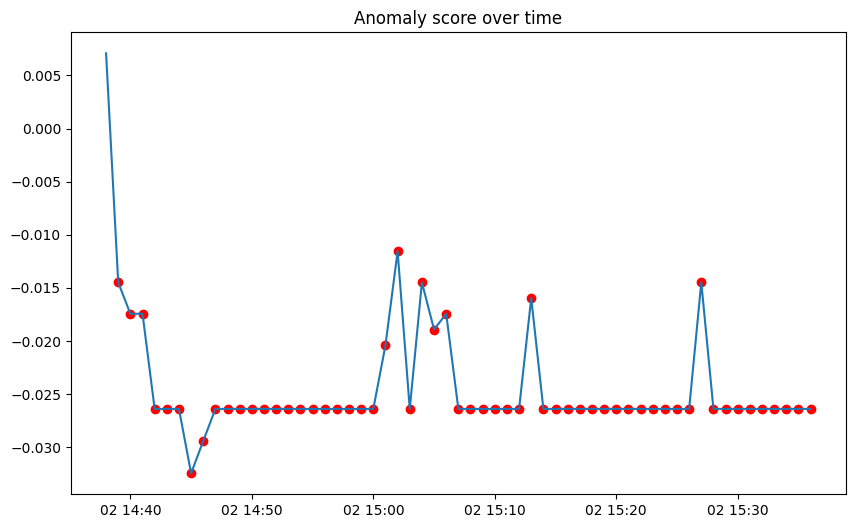

In [408]:
plt.figure(figsize=(10, 6))
plt.plot(unknown_features.index, anomaly_scores, label="Anomaly Score")
plt.scatter(unknown_features.index[anomalies == -1], anomaly_scores[anomalies == -1], color="red", label="Anomalies")
plt.title("Anomaly score over time")
plt.show()

Anomaly scores over time for Isolation Forest show that the traffic in the first few minutes of the unknown period are not that high, indicating lower confidence (values closer to -1 are associated with higher confidence).

The plot implies that benign traffic is more rare in the unknown period of time (periodic beaconing with more positive scores -> lower confidence).

Important note: there is no data point explicitly flagged as an anomaly (no score = -1). For this reason, if we were to solely rely on the strict criterion that only data points with anomaly scores equal to -1 are possible anomalies, this method would be of no use. For this reason, I will treat later data points with scores < -0.02 as anomalies. 

In [409]:
# One-class SVM
from sklearn.svm import OneClassSVM
oc_svm = OneClassSVM(gamma="auto", nu=0.5)
oc_svm.fit(benign_features)
oc_anomaly_scores = oc_svm.decision_function(unknown_features)
oc_anomalies = oc_svm.predict(unknown_features)
print("Anomalies in the unknown period (One-class SVM):")
unknown_features[oc_anomalies == -1]

Anomalies in the unknown period (One-class SVM):


,unique_dest_ips,unique_dest_ports,total_orig_bytes,total_resp_bytes,conn_state_diversity,count_queries,unique_queries,new_domains_count,id.resp_h,id.resp_p,orig_bytes,resp_bytes
ts,,,,,,,,,,,,
2020-09-02 14:38:00,9,4,151244,29638,4,7.0,7.0,4.0,9,4,151244,29638
2020-09-02 14:39:00,3,3,5615,2621,2,1.0,1.0,1.0,3,3,5615,2621
2020-09-02 14:40:00,2,2,33534,1408,1,1.0,1.0,0.0,2,2,33534,1408
2020-09-02 14:41:00,2,2,1059,929,2,1.0,1.0,1.0,2,2,1059,929
2020-09-02 14:42:00,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0
2020-09-02 14:43:00,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0
2020-09-02 14:44:00,1,1,0,0,1,0.0,0.0,0.0,1,1,0,0
2020-09-02 14:45:00,4,4,4551,4146,4,1.0,1.0,1.0,4,4,4551,4146
2020-09-02 14:46:00,1,1,693689,1546,2,0.0,0.0,0.0,1,1,693689,1546


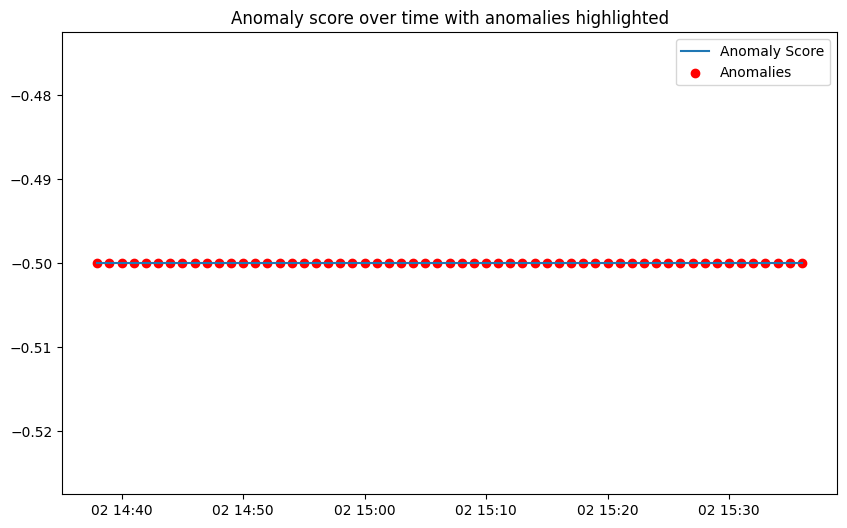

In [410]:
plt.figure(figsize=(10, 6))
plt.plot(unknown_features.index, oc_anomaly_scores, label="Anomaly Score")
plt.scatter(unknown_features.index[oc_anomalies == -1], oc_anomaly_scores[oc_anomalies == -1], color="red", label="Anomalies")
plt.title("Anomaly score over time with anomalies highlighted")
plt.legend()
plt.show()

The plot above shows that One-Clas SVM contributes with very little value to the anomaly detection, as every anomalous data point has a score of -0.5, meaning there might be no anomalies at all (or at least it's not very telling), similarly to the previous Isolation Forest comment. 

To ensure One-Class SVM and the idea of the robust approach is of use, I will treat data points as anomalous if they got scores < -0.5

In [411]:
# Compare the overlap of anomalies detected by both methods
anomalies_iso = set(unknown_features.index[anomalies == -1])
anomalies_oc_svm = set(unknown_features.index[oc_anomalies == -1])
overlap_anomaly = anomalies_iso.intersection(anomalies_oc_svm)

overlap_anomaly

{Timestamp('2020-09-02 14:39:00'),
 Timestamp('2020-09-02 14:40:00'),
 Timestamp('2020-09-02 14:41:00'),
 Timestamp('2020-09-02 14:42:00'),
 Timestamp('2020-09-02 14:43:00'),
 Timestamp('2020-09-02 14:44:00'),
 Timestamp('2020-09-02 14:45:00'),
 Timestamp('2020-09-02 14:46:00'),
 Timestamp('2020-09-02 14:47:00'),
 Timestamp('2020-09-02 14:48:00'),
 Timestamp('2020-09-02 14:49:00'),
 Timestamp('2020-09-02 14:50:00'),
 Timestamp('2020-09-02 14:51:00'),
 Timestamp('2020-09-02 14:52:00'),
 Timestamp('2020-09-02 14:53:00'),
 Timestamp('2020-09-02 14:54:00'),
 Timestamp('2020-09-02 14:55:00'),
 Timestamp('2020-09-02 14:56:00'),
 Timestamp('2020-09-02 14:57:00'),
 Timestamp('2020-09-02 14:58:00'),
 Timestamp('2020-09-02 14:59:00'),
 Timestamp('2020-09-02 15:00:00'),
 Timestamp('2020-09-02 15:01:00'),
 Timestamp('2020-09-02 15:02:00'),
 Timestamp('2020-09-02 15:03:00'),
 Timestamp('2020-09-02 15:04:00'),
 Timestamp('2020-09-02 15:05:00'),
 Timestamp('2020-09-02 15:06:00'),
 Timestamp('2020-09-

In [499]:
len(benign_features), len(unknown_features),
# len(anomaly_scores)

(5, 59)

In [455]:
# Add both anomaly scores to the features dataframe
new_features_df = features_df.copy()
new_features_df["iso_score"] = iso.decision_function(features_df) 
new_features_df["oc_svm_score"] = oc_svm.decision_function(features_df) 
new_features_df

,unique_dest_ips,unique_dest_ports,total_orig_bytes,total_resp_bytes,conn_state_diversity,count_queries,unique_queries,new_domains_count,id.resp_h,id.resp_p,orig_bytes,resp_bytes,iso_score,oc_svm_score
ts,,,,,,,,,,,,,,
2020-09-02 14:33:00,6,4,103533,15781739,2,8.0,7.0,0.0,6,4,103533,15781739,0.000000,0.0
2020-09-02 14:34:00,7,3,59876,19298095,3,11.0,10.0,0.0,7,3,59876,19298095,0.047438,0.0
2020-09-02 14:35:00,9,2,19906,49435,1,9.0,9.0,0.0,9,2,19906,49435,0.039653,0.0
2020-09-02 14:36:00,15,4,70336,230303,3,13.0,13.0,0.0,15,4,70336,230303,-0.014487,0.0
2020-09-02 14:37:00,4,2,15250,10391,5,3.0,3.0,0.0,4,2,15250,10391,-0.029412,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-02 15:32:00,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,-0.026392,-0.5
2020-09-02 15:33:00,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,-0.026392,-0.5
2020-09-02 15:34:00,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,-0.026392,-0.5


Text(0.5, 0, 'Anomaly Score')

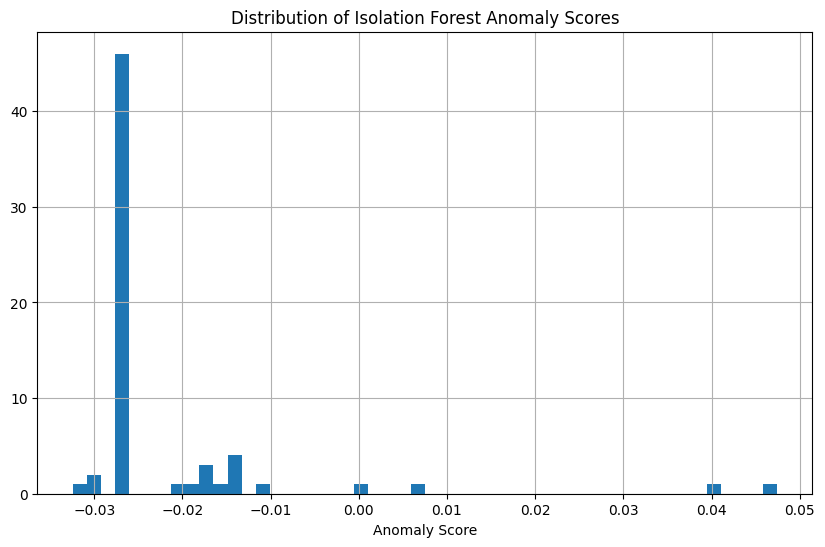

In [480]:
new_features_df["iso_score"].hist(bins=50, figsize=(10, 6))
plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")

Text(0.5, 0, 'Anomaly Score')

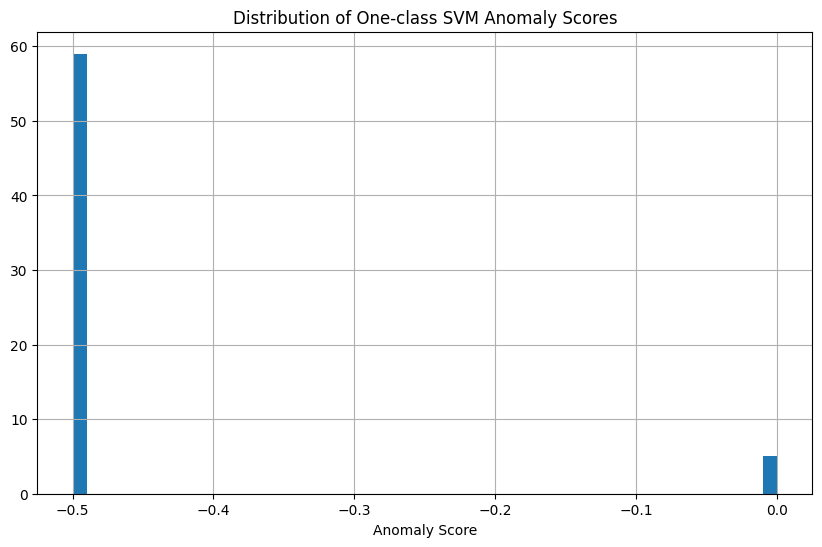

In [481]:
new_features_df["oc_svm_score"].hist(bins=50, figsize=(10, 6))
plt.title("Distribution of One-class SVM Anomaly Scores")
plt.xlabel("Anomaly Score")

The previous plots show the distribution of anomaly scores. Based on these plots, the adjusted anomaly score thresholds for both methods were derived ([-1; -0.02)) for Isolation Forest and [-1; -0.5] for One-Class SVM)

In [500]:
# flag as anomaly based on the adjusted thresholds for both methods 
new_features_df["anomaly_iso"] = new_features_df["iso_score"] < -0.02
new_features_df["anomaly_oc_svm"] = new_features_df["oc_svm_score"] <= -0.5
new_features_df["anomaly_fire"] = new_features_df["anomaly_iso"] & new_features_df["anomaly_oc_svm"]

In [483]:
new_features_df.head(10)

,unique_dest_ips,unique_dest_ports,total_orig_bytes,total_resp_bytes,conn_state_diversity,count_queries,unique_queries,new_domains_count,id.resp_h,id.resp_p,orig_bytes,resp_bytes,iso_score,oc_svm_score,anomaly_iso,anomaly_oc_svm,anomaly_fire
ts,,,,,,,,,,,,,,,,,
2020-09-02 14:33:00,6,4,103533,15781739,2,8.0,7.0,0.0,6,4,103533,15781739,0.000000,0.0,False,False,False
2020-09-02 14:34:00,7,3,59876,19298095,3,11.0,10.0,0.0,7,3,59876,19298095,0.047438,0.0,False,False,False
2020-09-02 14:35:00,9,2,19906,49435,1,9.0,9.0,0.0,9,2,19906,49435,0.039653,0.0,False,False,False
2020-09-02 14:36:00,15,4,70336,230303,3,13.0,13.0,0.0,15,4,70336,230303,-0.014487,0.0,False,False,False
2020-09-02 14:37:00,4,2,15250,10391,5,3.0,3.0,0.0,4,2,15250,10391,-0.029412,0.0,True,False,False
2020-09-02 14:38:00,9,4,151244,29638,4,7.0,7.0,4.0,9,4,151244,29638,0.007083,-0.5,False,True,False
2020-09-02 14:39:00,3,3,5615,2621,2,1.0,1.0,1.0,3,3,5615,2621,-0.014487,-0.5,False,True,False
2020-09-02 14:40:00,2,2,33534,1408,1,1.0,1.0,0.0,2,2,33534,1408,-0.017437,-0.5,False,True,False
2020-09-02 14:41:00,2,2,1059,929,2,1.0,1.0,1.0,2,2,1059,929,-0.017437,-0.5,False,True,False


In [484]:
new_features_df["anomaly_fire"].value_counts()

anomaly_fire
True     49
False    15
Name: count, dtype: int64

These are the data that are flagged by both methods (49). The rest is considered benign

In [485]:
# Let's go with kernel SVM with RBF kernel and see how it performs (noisy and small data)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = new_features_df.copy()
df["ml_label"] = 0 # all benign
df.loc[df["anomaly_fire"], "ml_label"] = 1 # label anomalies as 1   

train_mask = (df.index < start_time_unknown) | (df["anomaly_fire"] == True)

train_df = df.loc[train_mask].copy() 
test_df = df.loc[~train_mask].copy()

print(f"Training set: {len(train_df)} samples, {train_df['ml_label'].sum()} anomalies")
print(f"Test set: {len(test_df)} samples, {test_df['ml_label'].sum()} anomalies")

Training set: 54 samples, 49 anomalies
Test set: 10 samples, 0 anomalies


This split makes the label distribution highly imbalanced. For this reason, I will take the first 10 minutes of the capture (approx 25% of data) as the training set and the rest will be reserved for training. The output of the following cell still shows highly imbalanced sets, but this mirrors the real behavior in the network. 

In [489]:
train_end_time = pd.Timedelta(minutes=10) # refer to the plot of anomaly scores 
start_time_test = start_time + train_end_time

train_df = df.loc[df.index <= start_time_test].copy()
test_df = df.loc[df.index > start_time_test].copy()


print("Train window range:", train_df.index.min(), "to", train_df.index.max())
print("Test window range:", test_df.index.min(), "to", test_df.index.max())
print(f"Training set: {len(train_df)} samples, {train_df['ml_label'].sum()} anomalies")
print(f"Test set: {len(test_df)} samples, {test_df['ml_label'].sum()} anomalies")

Train window range: 2020-09-02 14:33:00 to 2020-09-02 14:43:00
Test window range: 2020-09-02 14:44:00 to 2020-09-02 15:36:00
Training set: 11 samples, 2 anomalies
Test set: 53 samples, 47 anomalies


In [490]:
train_df.columns

Index(['unique_dest_ips', 'unique_dest_ports', 'total_orig_bytes',
       'total_resp_bytes', 'conn_state_diversity', 'count_queries',
       'unique_queries', 'new_domains_count', 'id.resp_h', 'id.resp_p',
       'orig_bytes', 'resp_bytes', 'iso_score', 'oc_svm_score', 'anomaly_iso',
       'anomaly_oc_svm', 'anomaly_fire', 'ml_label'],
      dtype='str')

In [491]:
X_train = train_df.drop(columns=["ml_label", "anomaly_iso", "anomaly_oc_svm", "anomaly_fire"])
y_train = train_df["ml_label"].astype(int)

X_test = test_df.drop(columns=["ml_label", "anomaly_iso", "anomaly_oc_svm", "anomaly_fire"])
y_test = test_df["ml_label"].astype(int)

print("Training set features shape:", X_train.shape)
print("Test set features shape:", X_test.shape)

Training set features shape: (11, 14)
Test set features shape: (53, 14)


In [492]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [493]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
probs = rf.predict_proba(X_test_scaled)[:, 1]
preds = rf.predict(X_test_scaled)

print("Classification Report:" , classification_report(y_test, preds, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("ROC AUC Score:", roc_auc_score(y_test, probs))
print("Average Precision Score:", average_precision_score(y_test, probs))

Classification Report:               precision    recall  f1-score   support

           0     0.6667    1.0000    0.8000         6
           1     1.0000    0.9362    0.9670        47

    accuracy                         0.9434        53
   macro avg     0.8333    0.9681    0.8835        53
weighted avg     0.9623    0.9434    0.9481        53

Confusion Matrix:
 [[ 6  0]
 [ 3 44]]
ROC AUC Score: 0.9663120567375887
Average Precision Score: 0.9957259499544499


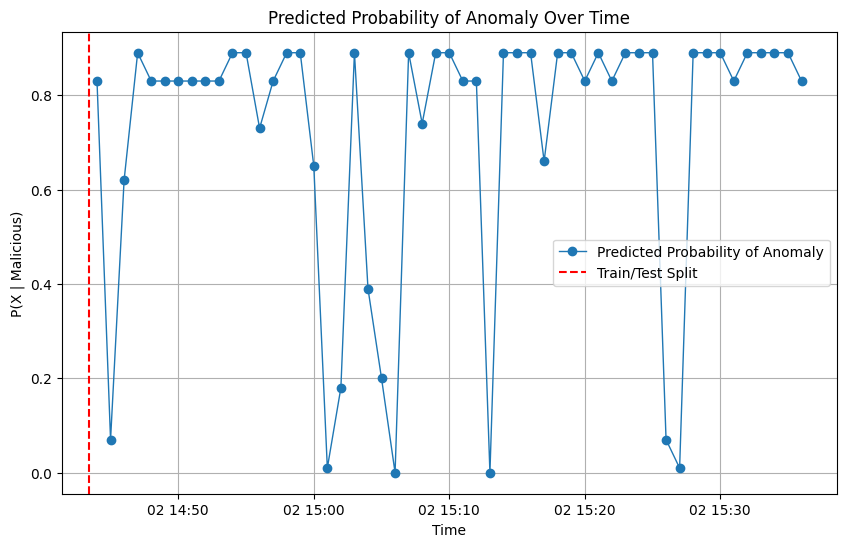

In [494]:
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, probs, marker="o",linewidth=1, label="Predicted Probability of Anomaly")
plt.axvline(start_time_test, color="red", linestyle="--", label="Train/Test Split")
plt.title("Predicted Probability of Anomaly Over Time")
plt.xlabel("Time")
plt.ylabel("P(X | Malicious)")
plt.legend()
plt.grid()
plt.show()

In [496]:
# fit svm
from sklearn.svm import SVC
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
svm_probs = svm.predict_proba(X_test_scaled)[:, 1]
svm_preds = svm.predict(X_test_scaled)
print("SVM Classification Report:" , classification_report(y_test, svm_preds, digits=4))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, svm_preds))
print("SVM ROC AUC Score:", roc_auc_score(y_test, svm_probs))
print("SVM Average Precision Score:", average_precision_score(y_test, svm_probs))


SVM Classification Report:               precision    recall  f1-score   support

           0     0.2143    1.0000    0.3529         6
           1     1.0000    0.5319    0.6944        47

    accuracy                         0.5849        53
   macro avg     0.6071    0.7660    0.5237        53
weighted avg     0.9111    0.5849    0.6558        53

SVM Confusion Matrix:
 [[ 6  0]
 [22 25]]
SVM ROC AUC Score: 0.9822695035460993
SVM Average Precision Score: 0.9978368794326241


In [497]:
# fit logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
logreg_probs = logreg.predict_proba(X_test_scaled)[:, 1]
logreg_preds = logreg.predict(X_test_scaled)
print("Logistic Regression Classification Report:" , classification_report(y_test, logreg_preds, digits=4))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, logreg_preds))
# print("Logistic Regression ROC AUC Score:", roc_auc_score(y_test, logreg, reg_probs))
print("Logistic Regression Average Precision Score:", average_precision_score(y_test, logreg_probs))

Logistic Regression Classification Report:               precision    recall  f1-score   support

           0     0.2143    1.0000    0.3529         6
           1     1.0000    0.5319    0.6944        47

    accuracy                         0.5849        53
   macro avg     0.6071    0.7660    0.5237        53
weighted avg     0.9111    0.5849    0.6558        53

Logistic Regression Confusion Matrix:
 [[ 6  0]
 [22 25]]
Logistic Regression Average Precision Score: 0.9949838140710814


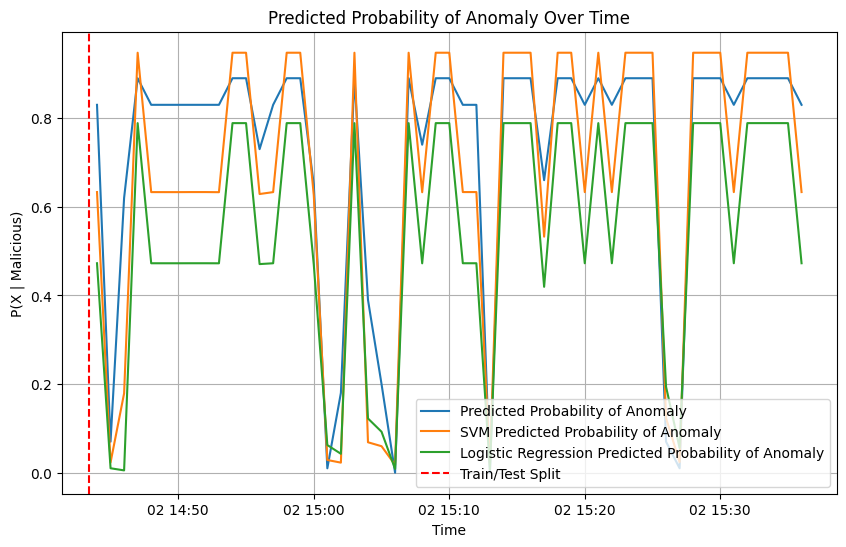

In [498]:
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, probs, label="Predicted Probability of Anomaly")
plt.plot(test_df.index, svm_probs, label="SVM Predicted Probability of Anomaly")
plt.plot(test_df.index, logreg_probs, label="Logistic Regression Predicted Probability of Anomaly")
plt.axvline(start_time_test, color="red", linestyle="--", label="Train/Test Split")
plt.title("Predicted Probability of Anomaly Over Time")
plt.xlabel("Time")
plt.ylabel("P(X | Malicious)")
plt.legend()
plt.grid()
plt.show()

The best results (recall and F1 score) are achieved by the Random Forest model, suggesting there are strong non-linear relationships. Random Forest achieves higher recall than both SVM and LR, implying the model produced less FPs (FPs in the sense of my labels, the results should be more indicative rather than definitive). Random Forest also surpasses the other two models in F1 scores, which makes it the most reliable model from all experiments. Precision in all three models is 1.00 which could be caused by a very few benign samples in the test set (and therefore a bias)